# Ch2

In [3]:
from typing import *
import os
from glob import glob
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nptyping import NDArray
from IPython.display import display

# 型推定
from matplotlib.figure import Figure
from matplotlib.axes._subplots import Subplot

sns.set_style('whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

cmap = sns.diverging_palette(255, 0, as_cmap=True)  # カラーパレットの定義

## 1D グリッドワールド

In [4]:
class Gridworld:
    def __init__(self, size: int = 8, goals : List[int] = 7, penalty: int = 0) -> None:
        self.size : int = size
        self.goals : List[int] = goals
        self.penalty : int = penalty

        self.states : List[int] = list(range(size))  # 全ての状態のindex
        self.actions : List[int] = [-1, 1]  # 全てのアクションのindex
        self.policy : Dict[Tuple[int, int], float] = {}  # (state, action)をkey、行動ポリシー確率をvalue
        self.value : Dict[int, int] = {s: 0 for s in self.states}  # 状態価値関数を保存

    def move(self, state: int, action: int) -> Tuple[int, int]:
        """現在の状態とアクションを受けて、報酬と次の状態を返却(今回は確率的遷移は存在しない)"""
        if state in self.goals:
            return 0, state
        new_state : int = state + action
        if new_state not in self.states:
            return self.penalty, state
        if new_state in self.goals:
            return 1, new_state
        return self.penalty, new_state


def show_values(world: Gridworld, subplot: Optional[Subplot] = None, title : str ='values') -> None:
    if subplot is None:
        fig : Figure = plt.figure(figsize=(world.size*0.8, 1.7))
        subplot : Subplot = fig.add_subplot(1, 1, 1)

    result : NDArray[(1, world.size), float] = np.zeros([1, world.size])
    for state in world.states:
        result[0][state] = world.value[state]
    sns.heatmap(result, cmap=cmap, square=True, cbar=False, yticklabels=[], annot=True, fmt='3.1f', ax=subplot).set_title(title)


def policy_eval(world: Gridworld, gamma: float = 1.0, trace: bool = False):
    if trace:
        fig : Figure = plt.figure(figsize=(world.size*0.8, len(world.states)*1.7))
    
    for state in world.states:
        new_value : float = 0
        # ベルマン方程式の計算
        for action in world.actions:
            reward, new_state = world.move(state=state, action=action)
            new_value += world.policy[(state, action)] * (reward + gamma * world.value[new_state])
        world.value[state] = new_value

        if trace:
            subplot : Subplot = fig.add_subplot(world.size, 1, state+1)
            show_values(world=world, subplot=subplot, title=f'update on state={state}')

### 右に進み続ける場合

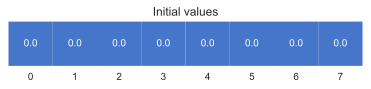

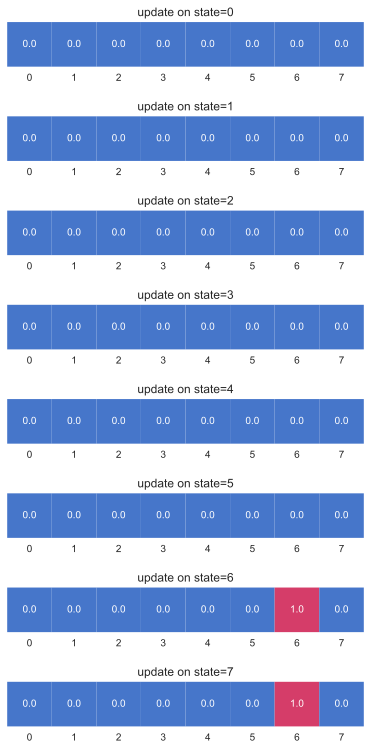

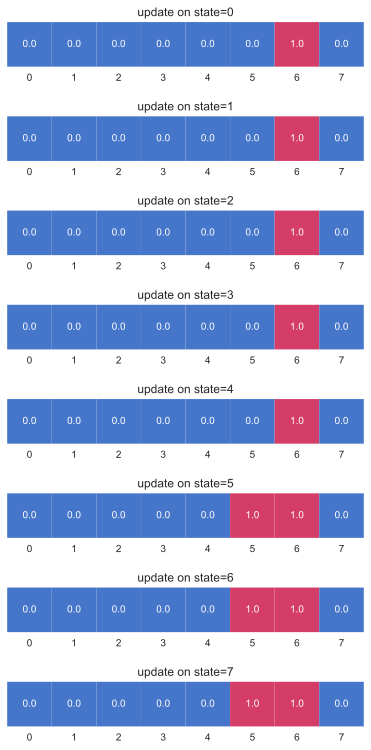

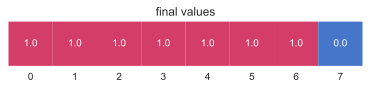

In [5]:
world : Gridworld = Gridworld(size=8, goals=[7])
for state in world.states:
    world.policy[(state, 1)] = 1.0
    world.policy[(state, -1)] = 0.0

show_values(world=world, title='Initial values')  # 初期状態の表示
policy_eval(world=world, trace=True)  # 1サイクル後の状態価値関数
policy_eval(world=world, trace=True)  # 2サイクル後の状態価値関数

# さらに5サイクル繰り返し、最終結果を表示
for _ in range(5):
    policy_eval(world=world)
show_values(world=world, title='final values')

### 行動ポリシーを左右ランダムにした場合

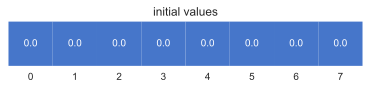

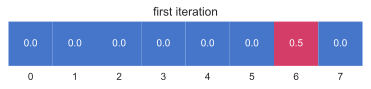

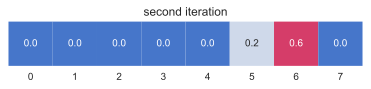

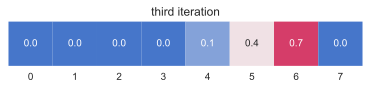

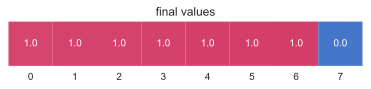

In [6]:
world : Gridworld = Gridworld(size=8, goals=[7])
for state in world.states:
    world.policy[(state, -1)] = 0.5
    world.policy[(state, 1)] = 0.5
    
show_values(world=world, title='initial values')  # 初期状態の表示
# 1サイクル後の状態価値関数
policy_eval(world=world)
show_values(world=world, title='first iteration')
# 2サイクル後の状態価値関数
policy_eval(world=world)
show_values(world=world, title='second iteration')
# 3サイクル後の状態価値関数
policy_eval(world=world)
show_values(world=world, title='third iteration')

# 100サイクル後の状態価値関数
for _ in range(100):
    policy_eval(world=world)
show_values(world=world, title='final values')

### 終了状態遷移以外に-1の報酬を課した場合

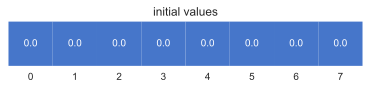

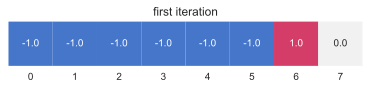

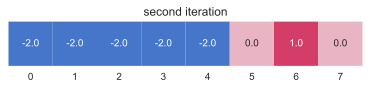

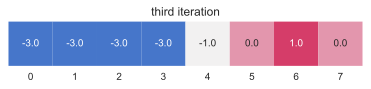

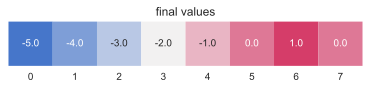

In [7]:
world : Gridworld = Gridworld(size=8, goals=[7], penalty=-1)
for state in world.states:
    world.policy[(state, 1)] = 1.0
    world.policy[(state, -1)] = 0.0

show_values(world=world, title='initial values')  # 初期状態の表示

# 1サイクル後の状態価値関数
policy_eval(world=world)
show_values(world=world, title='first iteration')
# 2サイクル後の状態価値関数
policy_eval(world=world)
show_values(world=world, title='second iteration')
# 3サイクル後の状態価値関数
policy_eval(world=world)
show_values(world=world, title='third iteration')

# 100サイクル後の状態価値関数
for _ in range(100):
    policy_eval(world=world)
show_values(world=world, title='final values')

## 2D グリッドワールド

### 確率的遷移なし

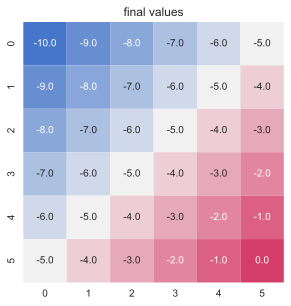

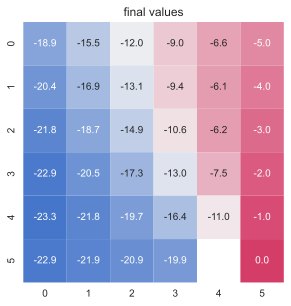

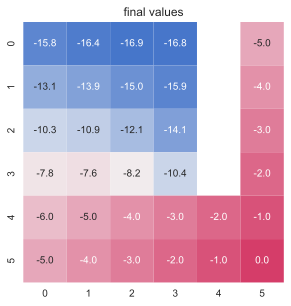

In [17]:
Coord = Tuple[int, int]

class Gridworld:
    def __init__(self, size: int = 6, traps: List[Coord] = []) -> None:
        self.size : int = size
        self.traps : List[Coord] = traps
        self.start : Coord = (0, 0)
        self.gola : Coord = (size-1, size-1)

        self.states : List[Coord] = [(x, y) for x in range(size) for y in range(size)]
        self.actions : List[Coord] = [(-1, 0), (0, -1), (1, 0), (0, 1)]  # (左, 上, 右, 下)に移動
        self.policy : Dict[Tuple[Coord, Coord], float] = {}  # 行動ポリシー確率
        for state in self.states:
            self.policy[state, self.actions[0]] = 0
            self.policy[state, self.actions[1]] = 0
            self.policy[state, self.actions[2]] = 1/2
            self.policy[state, self.actions[3]] = 1/2
        self.value : Dict[Coord, float] = {state: 0 for state in self.states}  # 状態価値関数

    def move(self, state: Coord, action: Coord) -> Tuple[int, Coord]:
        """現在の状態とアクションを受けて、報酬と次の状態を返却(今回は確率的遷移は存在しない)"""
        if state == self.gola:
            return 0, state
        new_state : Coord = (state[0] + action[0], state[1] + action[1])
        if new_state not in self.states:
            return 0, state
        if new_state in self.traps:
            return -1, self.start
        return -1, new_state


def show_values(world: Gridworld, subplot: Optional[Subplot] = None, title: str = 'Values'):
    if subplot is None:
        fig : Figure = plt.figure(figsize=(world.size*0.8, world.size*0.8))
        subplot : Subplot = fig.add_subplot(1, 1, 1)

    result : NDArray[(world.size, world.size), Optional[float]] = np.zeros([world.size, world.size])
    for (x, y) in world.states:
        if (x, y) in world.traps:
            result[y][x] = None
        else:
            result[y][x] = world.value[(x, y)]
    sns.heatmap(result, cmap=cmap, square=True, cbar=False, annot=True, fmt='3.1f', ax=subplot).set_title(title)


def policy_eval(world: Gridworld, gamma: float = 1.0, delta: float = 0.01) -> None:
    """状態価値関数の更新値がdelta未満になるまで処理"""
    while True:
        delta_max : float = 0.0
        for state in world.states:
            new_value : float = 0.0
            # ベルマン方程式の計算
            for action in world.actions:
                reward, new_state = world.move(state, action)
                new_value += world.policy[(state, action)] * (reward + gamma * world.value[new_state])
            delta_max = max(delta_max, abs(world.value[state] - new_value))  # 状態価値関数の更新値の最大値
            world.value[state] = new_value

        if delta_max < delta:
            break



# トラップをもたない場合
world : Gridworld = Gridworld(size=6)
policy_eval(world=world)
show_values(world=world, title='final values')

# 1つだけトラップをもつ場合
world : Gridworld = Gridworld(size=6, traps=[(4, 5)])
policy_eval(world=world)
show_values(world=world, title='final values')

# 4つトラップをもつ場合
world : Gridworld = Gridworld(size=6, traps=[(4, y) for y in range(4)])
policy_eval(world=world)
show_values(world=world, title='final values')

### 確率的遷移あり

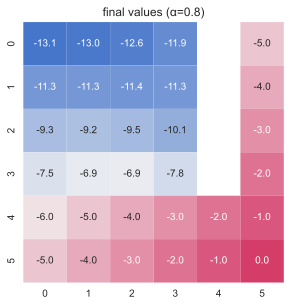

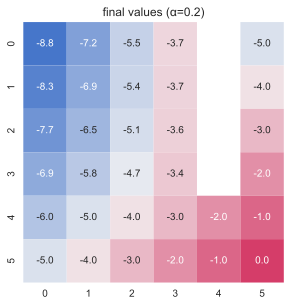

In [19]:
Coord = Tuple[int, int]

class Gridworld:
    def __init__(self, size: int = 6, traps: List[Coord] = [], alpha: float = 0.0) -> None:
        self.size : int = size
        self.traps : List[Coord] = traps
        self.alpha : float = alpha
        self.start : Coord = (0, 0)
        self.goal : Coord = (size-1, size-1)

        self.states : List[Coord] = [(x, y) for x in range(size) for y in range(size)]
        self.actions : List[Coord] = [(-1, 0), (0, -1), (1, 0), (0, 1)]  # (左, 上, 右, 下)に移動
        self.policy : Dict[Tuple[Coord, Coord], float] = {}  # 行動ポリシー確率
        for state in self.states:
            self.policy[state, self.actions[0]] = 0
            self.policy[state, self.actions[1]] = 0
            self.policy[state, self.actions[2]] = 1/2
            self.policy[state, self.actions[3]] = 1/2
        self.value : Dict[Coord, float] = {state: 0 for state in self.states}  # 状態価値関数

    def move(self, state: Coord, action: Coord) -> List[Tuple[float, int, Coord]]:
        """現在の状態、アクションを受けて、[(遷移確率, 報酬, 次の状態), ...]を返却"""
        if state == self.goal:
            return [(1.0, 0, state)]
        new_state : Coord = (state[0] + action[0], state[1] + action[1])
        if new_state not in self.states:
            return [(1.0, 0, state)]
        if new_state in self.traps:
            return [(self.alpha, -1, self.start), (1-self.alpha, -1, self.goal)]
        return [(1.0, -1, new_state)]


def policy_eval(world: Gridworld, gamma: float = 1.0, delta: float = 0.01) -> None:
    """状態価値関数の更新値がdelta未満になるまで処理"""
    while True:
        delta_max : float = 0.0
        for state in world.states:
            new_value : float = 0.0
            # ベルマン方程式の計算
            for action in world.actions:
                results : List[Tuple[float, int, Coord]] = world.move(state=state, action=action)
                for prob, reward, new_state in results:
                    new_value += world.policy[(state, action)] * prob * (reward + gamma * world.value[new_state])            
            delta_max = max(delta_max, abs(world.value[state] - new_value))  # 状態価値関数の更新値の最大値
            world.value[state] = new_value
        if delta_max < delta:
            break



# 4つトラップをもつ場合(α=0.8)
world : Gridworld = Gridworld(size=6, traps=[(4, y) for y in range(4)], alpha=0.8)
policy_eval(world=world)
show_values(world=world, title='final values (α=0.8)')

# 4つトラップをもつ場合(α=0.2)
world : Gridworld = Gridworld(size=6, traps=[(4, y) for y in range(4)], alpha=0.2)
policy_eval(world=world)
show_values(world=world, title='final values (α=0.2)')